In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [2]:
## Let's start by loading our data

# Starting with the labels
with open("./data/processed_training_labels.csv") as labels_file:
    labels_string = labels_file.read()
    labels = np.array(labels_string.split(','), dtype=int)
    
# Recall we had 60000 images. Let's make sure we didn't lose anythin
assert len(labels) == 60000

# Now for the images
images = []
with open("./data/processed_training_images") as images_file:
    raw_image_strings = images_file.readlines()
    for img_string in raw_image_strings:
        img_flat = np.array(img_string.split(","), dtype=np.double)
        img = np.reshape(img_flat, (28,28))
        images.append(img)
        
# Again, let's do some random spot checking to make sure everything is as we expect
assert len(images) == 60000
i1,i2,i3 = np.random.randint(0, 60000, 3)
assert images[i1].shape == (28,28)
assert images[i2].shape == (28,28)
assert images[i3].shape == (28,28)

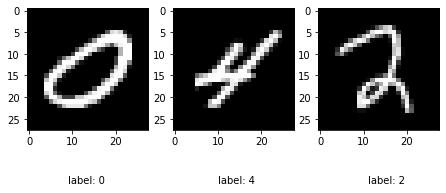

In [3]:
# And again, we'll just print out some images and their labels for good measure 
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,4,1)
plt.text(9,40,f"label: {labels[i1]}")
plt.imshow(images[i1], cmap='gray')
fig.add_subplot(1,4,2)
plt.text(10,40,f"label: {labels[i2]}")
plt.imshow(images[i2], cmap='gray')
fig.add_subplot(1,4,3)
plt.text(11,40,f"label: {labels[i3]}")
plt.imshow(images[i3], cmap='gray')

In [4]:
## Okay! Now the fun begins.
# To start, let's just get everything over to Torch
t_labels = torch.tensor(labels)
t_images = torch.tensor(images)

In [5]:
# And we can take a look at their shapes
print(t_labels.shape)
print(t_images.shape)
len(t_images)

torch.Size([60000])
torch.Size([60000, 28, 28])


60000

In [6]:
# TODO: !DF! Try just one fully connected layer
# TODO: !DF! Write explanation on MSELoss()
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(1,1,3)
        self.fc1 = nn.Linear(782, 80)
        self.fc2 = nn.Linear(80, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [7]:
net = Net()
net = net.float()

In [8]:
criterion = nn.MSELoss()
#optimizer = optim.SGD(net.parameters(), lr=0.01)
for epoch in range(3):
    running_loss = 0.0
    for i in range(0,len(t_images), 4):
        raw_batch = t_images[i:i+4]
        batch = torch.zeros(4,1,784)
        for j, img in enumerate(raw_batch):
            batch[j] = img.flatten().double()
        batch_labels = t_labels[i:i+4]
        targets = torch.zeros(len(batch_labels),10)
        for k,t in enumerate(targets):
            label = batch_labels[k]
            t[label] = 1
        
        net.zero_grad()
        out = net(batch)
        loss = criterion(out, targets)
        loss.backward()
        running_loss += loss.item()
        if i % 2000 == 0:
            ## I recommend doing things like this. It helped me catch mistakes
            #print(batch[0][0])
            #plt.imshow(batch[0][0].reshape((28,28)), cmap='gray')
            #plt.show()
            #print(targets[0])
            print(f"Epoch: {epoch}, Batch: {i}, running_loss: {running_loss}")
            running_loss = 0.0
        for f in net.parameters():
            f.data.sub_(f.grad.data * 0.01)
        
    

/home/finn/miniconda3/envs/pytorch-mnist/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([4, 10])) that is different to the input size (torch.Size([4, 1, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, Batch: 0, running_loss: 3.0109519958496094
Epoch: 0, Batch: 2000, running_loss: 47.93267650157213
Epoch: 0, Batch: 4000, running_loss: 45.17565347999334
Epoch: 0, Batch: 6000, running_loss: 45.02662651985884
Epoch: 0, Batch: 8000, running_loss: 45.01464667916298
Epoch: 0, Batch: 10000, running_loss: 44.94611784815788
Epoch: 0, Batch: 12000, running_loss: 44.976879589259624
Epoch: 0, Batch: 14000, running_loss: 44.918387681245804
Epoch: 0, Batch: 16000, running_loss: 44.883284851908684
Epoch: 0, Batch: 18000, running_loss: 44.806061796844006
Epoch: 0, Batch: 20000, running_loss: 44.791739247739315
Epoch: 0, Batch: 22000, running_loss: 44.75615119189024
Epoch: 0, Batch: 24000, running_loss: 44.76686005294323
Epoch: 0, Batch: 26000, running_loss: 44.66662761569023
Epoch: 0, Batch: 28000, running_loss: 44.66918031871319
Epoch: 0, Batch: 30000, running_loss: 44.58419395238161
Epoch: 0, Batch: 32000, running_loss: 44.665855437517166
Epoch: 0, Batch: 34000, running_loss: 44.52830068

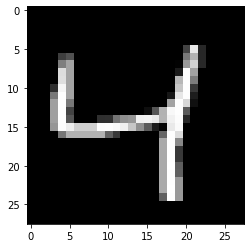

In [9]:
plt.imshow(t_images[2], cmap='gray')

In [11]:
torch.argmax(net(t_images[2].flatten().float().unsqueeze(0).unsqueeze(0)))

tensor(4)

In [12]:
with open("./data/processed_testing_labels.csv") as labels_file:
    labels_string = labels_file.read()
    testing_labels = np.array(labels_string.split(','), dtype=int)
    
# Recall we had 60000 images. Let's make sure we didn't lose anythin
assert len(testing_labels) == 10000

# Now for the images
testing_images = []
with open("./data/processed_testing_images") as images_file:
    raw_image_strings = images_file.readlines()
    for img_string in raw_image_strings:
        img_flat = np.array(img_string.split(","), dtype=np.double)
        img = np.reshape(img_flat, (28,28))
        testing_images.append(img)

In [13]:
t_test_labels = torch.tensor(testing_labels)
t_test_images = torch.tensor(testing_images)

In [20]:
test_imgs = t_test_images
test_labels = t_test_labels
correct = []
for i,img in enumerate(test_imgs):
    res = torch.argmax(net(img.flatten().float().unsqueeze(0).unsqueeze(0)))
    targ = test_labels[i]
    if res == targ:
        correct.append(1)
    else:
        correct.append(0)

print(f"{sum(correct)} / {len(correct)}")

8499 / 10000


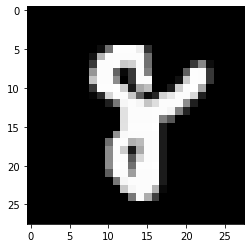

In [23]:
img = t_test_images[9496]
plt.imshow(img, cmap='gray')

In [24]:
torch.argmax(net(img.flatten().float().unsqueeze(0).unsqueeze(0)))

tensor(8)

In [ ]:
img.shape

In [ ]:
img.flatten().shape

In [19]:
torch.save(net, "./models/1dC2fc85")
torch.save(net.state_dict(), "./models/1dC2fc85.state_dict")